In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [4]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import confusion_matrix,cohen_kappa_score,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report,matthews_corrcoef
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn import metrics

In [5]:
Y = np.load('y_data_mfcc.npy')
X_flatten = np.load('x_data_reshaped.npy')

df = pd.DataFrame(X_flatten)
df['target'] = Y

df.shape

(831, 41)

### Labels number with meanings
### 1)  1: Artifacts Sounds
### 2)  2: Normal Sounds
### 3)  3: Extrahals Sounds
### 4)  4: Murmur sounds
### 5) -1: Unlabelled

In [6]:
train = df[df['target']!=-1]  # training dataset
test = df[df['target']==-1]   # unlabelled/test dataset

In [7]:
def model(steps,params,X,y):
    
    pipeline = Pipeline(steps)
    gv_model = GridSearchCV(pipeline,param_grid=params,cv=10)
    
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.15,random_state=42, shuffle = True)
    gv_model.fit(X_train,y_train)
    
    y_pred_train = gv_model.predict(X_train)
    y_pred_test = gv_model.predict(X_test)
    
    
    cross_val = cross_val_score(gv_model,X,y,cv=5)
    
    params = {
        'y_pred_train':y_pred_train,
        'y_pred_test':y_pred_test,
        'y_train':y_train,
        'y_test':y_test,
        'model':gv_model,
        'cross_val':cross_val
    }
    
    return params

In [8]:
def print_performance_metrics(y_test,pred_test):
  
    print('Accuracy:', np.round(metrics.accuracy_score(y_test,pred_test),4))
    print('Precision:', np.round(metrics.precision_score(y_test, 
                               pred_test,average='weighted'),4))
    print('Recall:', np.round(metrics.recall_score(y_test, pred_test,
                                               average='weighted'),4))
    print('F1 Score:', np.round(metrics.f1_score(y_test, pred_test,
                                               average='weighted'),4))
    print('Cohen Kappa Score:', np.round(metrics.cohen_kappa_score(y_test,pred_test),4))
    print('Matthews Corrcoef:', np.round(metrics.matthews_corrcoef(y_test,pred_test),4)) 
    #print('ROC AUC:', (metrics.roc_auc_score(y_test,pred_test,multi_class = 'ovo')))
    print('\t\tClassification Report:\n', metrics.classification_report(y_test, pred_test))
    mat = confusion_matrix(y_test,pred_test)
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [7]:
# SVC
steps = [('scaler',MinMaxScaler()),('svc',SVC(kernel='poly'))]
params = {'svc__C':[0.5,0.8,1],'svc__degree':[3,4,5]}

par_svc = model(steps,params,train.drop('target',axis=1),train['target'])

In [8]:
print('Mean Score of Validation of 10 Fold : {}'.format(np.mean(par_svc['cross_val'])))
print('Score of Training Set : {}'.format(accuracy_score(par_svc['y_train'],par_svc['y_pred_train'])))

Mean Score of Validation of 10 Fold : 0.691806660772178
Score of Training Set : 0.8326612903225806


Accuracy: 0.6364
Precision: 0.5873
Recall: 0.6364
F1 Score: 0.5957
Cohen Kappa Score: 0.3394
Matthews Corrcoef: 0.3631
		Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.71      0.83         7
           1       0.64      0.86      0.73        49
           2       0.50      0.33      0.40         9
           3       0.60      0.40      0.48        15
           4       0.00      0.00      0.00         8

    accuracy                           0.64        88
   macro avg       0.55      0.46      0.49        88
weighted avg       0.59      0.64      0.60        88



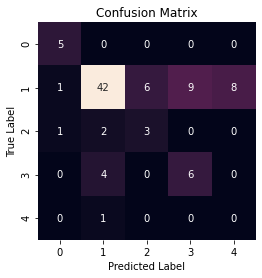

In [10]:
print_performance_metrics(par_svc['y_test'],par_svc['y_pred_test'])

In [9]:
# Decision Tree
steps = [('scaler',StandardScaler()),('tree',DecisionTreeClassifier())]
params = {
         'tree__criterion':['gini','entropy'],
        'tree__max_depth':[3,4,5,6],
        'tree__min_samples_split':[2,3,4,5],
        'tree__max_features':['sqrt','log2']
}
par_ds = model(steps,params,train.drop('target',axis=1),train['target'])

In [10]:
print('Mean Score of Validation of 10 Fold : {}'.format(np.mean(par_ds['cross_val'])))
print('Score of Training Set : {}'.format(accuracy_score(par_ds['y_train'],par_ds['y_pred_train'])))

Mean Score of Validation of 10 Fold : 0.6267757147067492
Score of Training Set : 0.7661290322580645


Accuracy: 0.6023
Precision: 0.4913
Recall: 0.6023
F1 Score: 0.539
Cohen Kappa Score: 0.2841
Matthews Corrcoef: 0.3021
		Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.57      0.62         7
           1       0.62      0.82      0.71        49
           2       0.00      0.00      0.00         9
           3       0.53      0.60      0.56        15
           4       0.00      0.00      0.00         8

    accuracy                           0.60        88
   macro avg       0.36      0.40      0.38        88
weighted avg       0.49      0.60      0.54        88



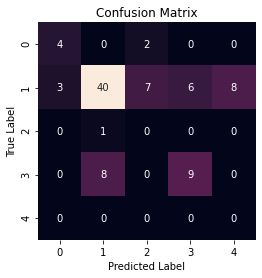

In [11]:
print_performance_metrics(par_ds['y_test'],par_ds['y_pred_test'])

In [27]:
# RandomForest
steps = [('rf',RandomForestClassifier())]
params = {'rf__n_estimators':[150,200,250],
          'rf__max_depth':[4,5],
          'rf__min_samples_split':[2],
          'rf__min_samples_leaf':[3],
          'rf__n_jobs':[-1]
         }
par_rf = model(steps,params,train.drop('target',axis=1),train['target'])

In [28]:
print('Mean Score of Validation of 10 Fold : {}'.format(np.mean(par_rf['cross_val'])))
print('Score of Training Set : {}'.format(accuracy_score(par_rf['y_train'],par_rf['y_pred_train'])))

Mean Score of Validation of 10 Fold : 0.6935307987032125
Score of Training Set : 0.782258064516129


Accuracy: 0.6591
Precision: 0.6414
Recall: 0.6591
F1 Score: 0.5712
Cohen Kappa Score: 0.3245
Matthews Corrcoef: 0.4139
		Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.86      0.86         7
           1       0.63      0.98      0.77        49
           2       0.50      0.11      0.18         9
           3       1.00      0.20      0.33        15
           4       0.00      0.00      0.00         8

    accuracy                           0.66        88
   macro avg       0.60      0.43      0.43        88
weighted avg       0.64      0.66      0.57        88



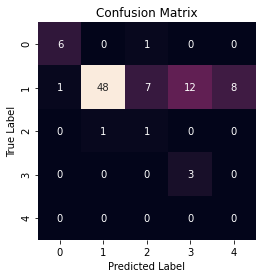

In [29]:
print_performance_metrics(par_rf['y_test'],par_rf['y_pred_test'])

In [30]:
# Gradient Boosting
steps = [('gbt',GradientBoostingClassifier())]
params = {
    'gbt__n_estimators':[50],
    'gbt__learning_rate':[0.1,0.5],
    'gbt__max_depth':[2,3],
    'gbt__min_samples_split':[3],
    'gbt__max_features':['log2','sqrt']
}
par_gbt = model(steps,params,train.drop('target',axis=1),train['target'])

In [31]:
print('Mean Score of Validation of 10 Fold : {}'.format(np.mean(par_gbt['cross_val'])))
print('Score of Training Set : {}'.format(accuracy_score(par_gbt['y_train'],par_gbt['y_pred_train'])))

Mean Score of Validation of 10 Fold : 0.7004126142057177
Score of Training Set : 0.9717741935483871


Accuracy: 0.6364
Precision: 0.5667
Recall: 0.6364
F1 Score: 0.5734
Cohen Kappa Score: 0.3172
Matthews Corrcoef: 0.3568
		Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.86      0.86         7
           1       0.63      0.90      0.74        49
           2       0.50      0.22      0.31         9
           3       0.57      0.27      0.36        15
           4       0.00      0.00      0.00         8

    accuracy                           0.64        88
   macro avg       0.51      0.45      0.45        88
weighted avg       0.57      0.64      0.57        88



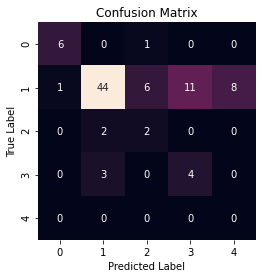

In [32]:
print_performance_metrics(par_gbt['y_test'],par_gbt['y_pred_test'])

In [34]:
# XGBoosting
steps = [('xgb',XGBClassifier())]
params = {
    'xgb__n_estimators':[120],
    'xgb__learning_rate':[0.08],
    'xgb__max_depth':[2,3],
    'xgb__gamma':[1]
}
par_xgb = model(steps,params,train.drop('target',axis=1),train['target'])

[01:07:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:07:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:07:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:07:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[01:07:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:07:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:07:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:07:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[01:07:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:07:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:07:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:07:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[01:07:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:07:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:07:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:07:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[01:08:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:08:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:08:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:08:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

In [35]:
print('Mean Score of Validation of 10 Fold : {}'.format(np.mean(par_xgb['cross_val'])))
print('Score of Training Set : {}'.format(accuracy_score(par_xgb['y_train'],par_xgb['y_pred_train'])))

Mean Score of Validation of 10 Fold : 0.7003831417624521
Score of Training Set : 0.8649193548387096


Accuracy: 0.6591
Precision: 0.6004
Recall: 0.6591
F1 Score: 0.606
Cohen Kappa Score: 0.3645
Matthews Corrcoef: 0.4036
		Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.71      0.83         7
           1       0.65      0.92      0.76        49
           2       0.50      0.33      0.40         9
           3       0.62      0.33      0.43        15
           4       0.00      0.00      0.00         8

    accuracy                           0.66        88
   macro avg       0.56      0.46      0.49        88
weighted avg       0.60      0.66      0.61        88



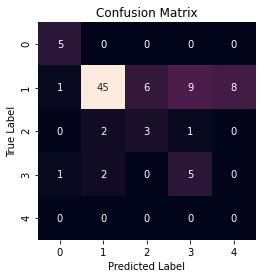

In [36]:
print_performance_metrics(par_xgb['y_test'],par_xgb['y_pred_test'])

In [41]:
# AdaBoost
clf_r = RandomForestClassifier(n_estimators=200,max_depth=5,min_samples_split=2,min_samples_leaf=3,n_jobs=-1)
steps = [('scaler',MinMaxScaler()),('adb',AdaBoostClassifier(clf_r))]
params = {
     'adb__n_estimators':[5,6],
    'adb__learning_rate':[0.01],
    'adb__algorithm':['SAMME.R']
}
par_adb = model(steps,params,train.drop('target',axis=1),train['target'])

In [42]:
print('Mean Score of Validation of 10 Fold : {}'.format(np.mean(par_adb['cross_val'])))
print('Score of Training Set : {}'.format(accuracy_score(par_adb['y_train'],par_adb['y_pred_train'])))

Mean Score of Validation of 10 Fold : 0.6866931918656057
Score of Training Set : 0.7862903225806451


Accuracy: 0.6591
Precision: 0.6414
Recall: 0.6591
F1 Score: 0.5712
Cohen Kappa Score: 0.3245
Matthews Corrcoef: 0.4139
		Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.86      0.86         7
           1       0.63      0.98      0.77        49
           2       0.50      0.11      0.18         9
           3       1.00      0.20      0.33        15
           4       0.00      0.00      0.00         8

    accuracy                           0.66        88
   macro avg       0.60      0.43      0.43        88
weighted avg       0.64      0.66      0.57        88



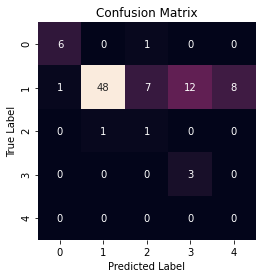

In [43]:
print_performance_metrics(par_adb['y_test'],par_adb['y_pred_test'])